<a href="https://colab.research.google.com/github/nonoumasy/Bicycle-Collisions-in-Los-Angeles-2013-2018/blob/master/Bicycle_Collisions_in_Los_Angeles_2013_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [2]:
!pip install -U geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 40.7MB/s 
     |████████████████████████████████| 14.7MB 32.0MB/s 


In [0]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

%matplotlib inline

In [0]:
df = pd.read_csv('https://opendata.arcgis.com/datasets/66d96f15d4e14e039caa6134e6eab8e5_0.csv', low_memory=False)

In [0]:
# Preprocess data

def clean_df(df):
  #column cleanup
  df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')  

  #drop duplicate rows
  df.drop_duplicates(keep='first')  

  #replaces missing values with a value
  df.fillna(value=0 ,inplace=True)  

  #use only these columns
  df = df[['accident_year','collision_date', 'timecat', 'collision_time', 'primary_rd', 'secondary_rd', 'direction', 'intersection',
           'hit_and_run','type_of_collision', 'road_surface', 'road_cond_1', 'lighting', 'bicycle_accident', 'alcohol_involved', 
           'count_bicyclist_killed', 'count_bicyclist_injured', 'point_x', 'point_y', 'match_addr', 'm_primaryrd', 'm_secondrd', 
           'pcf_viol_category', 'weather_1']]  

  #bicycle collisions dataset
  df = df[df['bicycle_accident'] == 'Y']

  #drop an outlier datapoint
  df = df[df.match_addr != '2ND ST & AZUSA AVE,, CA']

  # pad 0 values to time data
  df.collision_time = df.collision_time.map(str)
  df.collision_time = df.collision_time.str.zfill(4)
  df.collision_time = df.collision_time.str.ljust(6, '0')
  df.collision_time = df.collision_time.str.slice(0,2) + ':' + df.collision_time.str.slice(2,4) + ":" + df.collision_time.str.slice(4,6)
  df.collision_time = df.collision_time.str.replace('25:00:00', '23:00:00')

  # crop date data
  df.collision_date = df.collision_date.map(str)
  df.collision_date = df.collision_date.str.slice(0,10)

  # create new date_column
  df['date_time'] = df.collision_date + " " + df.collision_time

  # convert to datetime object
  df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S', yearfirst=True)

  #Replace type of collision with descriptive text based on SWITRS docs
  df.replace({'type_of_collision' : {'A' : 'Head On', 
                                   'B' : 'Sideswipe',
                                   'C' : 'Rear End',
                                   'D' : 'Broadside',
                                   'E' : 'Hit Object',
                                   'F' : 'Overturned',
                                   'G' : 'Vehicle/Pedestrian',
                                   'H' : 'Other',
                                   '-' : 'Not Stated'}}, inplace=True)

  #Replace weather with descriptive text based on SWITRS docs
  df.replace({'weather_1' : {'A' : 'Clear', 
                           'B' : 'Cloudy',
                           'C' : 'Raining',
                           'D' : 'Snowing',
                           'E' : 'Fog',
                           'F' : 'Other',
                           'G' : 'Wind',
                           'H' : 'Other',
                           '-' : 'Not Stated'}}, inplace=True)

  #Replace road surface with descriptive text based on SWITRS docs
  df.replace({'road_surface' : {'A' : 'Dry',
                              'B' : 'Wet',
                              'C' : 'Snowy or Icy',
                              'D' : 'Slippery (Muddy, Oily, etc.',
                              '-' : 'Not Stated',}}, inplace=True)

  #Replace road condition with descriptive text based on SWITRS docs
  df.replace({'road_cond_1' : {'A' : 'Holes, Deep Ruts', 
                           'B' : 'Loose Material on Roadway',
                           'C' : 'Obstruction on Roadway',
                           'D' : 'Construction or Repair Zone',
                           'E' : 'Reduced Roadway Width',
                           'F' : 'Flooded',
                           'G' : 'Other',
                           'H' : 'No Unusual Condition',
                           '-' : 'Not Stated'}}, inplace=True)



  #Replace hit and run with descriptive text based on SWITRS docs
  df.replace({'hit_and_run' : {'N' : 'Not Hit and Run',
                               'M' : 'Misdeamenor',
                               'F' : 'Felony'}}, inplace=True)


  #Replace Violation category with descriptive text based on SWITRS docs
  df.pcf_viol_category = df.pcf_viol_category.apply(str)
  df.replace({'pcf_viol_category' : {'0.0' : 'Unknown',
                                    '1.0' : 'Driving or Bicycling Under the Influence of Alcohol or Drug',
                                    '2.0' : 'Impeding Traffic',
                                    '3.0' : 'Unsafe Speed',
                                    '4.0' : 'Following Too Closely',
                                    '5.0' : 'Wrong Side of Road',
                                    '6.0' : 'Improper Passing',
                                    '7.0' : 'Unsafe Lane Change',
                                    '8.0' : 'Improper Turning',
                                    '9.0' : 'Automobile Right of Way',
                                    '10.0' : 'Pedestrian Right of Way',
                                    '11.0' : 'Pedestrian Violation',
                                    '12.0' : 'Traffic Signals and Signs',
                                    '13.0' : 'Hazardous Parking',
                                    '14.0' : 'Lights',
                                    '15.0' : 'Brakes',
                                    '16.0' : 'Other Equipment',
                                    '17.0' : 'Other Hazardous Violation',
                                    '18.0' : 'Other Than Driver (or Pedestrian)',
                                    '19.0' : ' ',
                                    '20.0' : ' ',
                                    '21.0' : 'Unsafe Starting or Backing',
                                    '22.0' : 'Other Improper Driving',
                                    '23.0' : 'Pedestrian or "Other" Under the Influence of Alcohol or Drug',
                                    '24.0' : 'Fell Asleep',
                                    '-' : 'Not Stated'}}, inplace=True)



  return df

df = clean_df(df)

In [41]:
df.head()

,accident_year,collision_date,timecat,collision_time,primary_rd,secondary_rd,direction,intersection,hit_and_run,type_of_collision,road_surface,road_cond_1,lighting,bicycle_accident,alcohol_involved,count_bicyclist_killed,count_bicyclist_injured,point_x,point_y,match_addr,m_primaryrd,m_secondrd,pcf_viol_category,weather_1,date_time
14,2016,2016-03-28,900,08:00:00,ARLINGTON AVENUE,VERNON AVENUE,S,N,Not Hit and Run,Broadside,Dry,No Unusual Condition,A,Y,0,0,1,-118.318218,34.003681,"ARLINGTON AVE & VERNON AVE, LOS ANGELES, CA",ARLINGTON AVE,VERNON AVE,12,Clear,2016-03-28 08:00:00
26,2018,2018-01-09,300,02:10:00,SOTO ST,8TH ST,N,N,Not Hit and Run,Broadside,Wet,No Unusual Condition,C,Y,0,1,0,-118.219046,34.028816,"SOTO ST & 8TH ST, LOS ANGELES, CA",SOTO ST,8TH ST,07,Raining,2018-01-09 02:10:00
36,2015,2015-01-21,900,08:25:00,WILTON PLACE,9TH STREET,0,Y,Not Hit and Run,Broadside,Dry,No Unusual Condition,A,Y,0,0,1,-118.314272,34.055843,"WILTON PL & 9TH ST, LOS ANGELES, CA",WILTON PL,9TH ST,05,Clear,2015-01-21 08:25:00
45,2013,2013-01-27,1200,11:00:00,VOSE STREET,SEPULVEDA BOULEVARD,W,N,Misdeamenor,Sideswipe,Wet,No Unusual Condition,A,Y,0,0,0,-118.466687,34.198444,"VOSE ST & SEPULVEDA BLVD, LOS ANGELES, CA",VOSE ST,SEPULVEDA BLVD,00,Raining,2013-01-27 11:00:00
60,2013,2013-01-10,1200,09:30:00,BLINN AVENUE,COLON STREET,S,N,Not Hit and Run,Broadside,Dry,No Unusual Condition,A,Y,0,0,1,-118.245457,33.791740,"BLINN AVE & COLON ST, LOS ANGELES, CA",BLINN AVE,COLON ST,05,Cloudy,2013-01-10 09:30:00


In [0]:
#change all columns to category type
for col in df.select_dtypes(['object']):   
    df[col] = df[col].astype('category')

In [0]:
#one hot encoding to replace categorical values into numerical ones
df_new = pd.get_dummies(df, columns=['direction', 'hit_and_run', 'road_surface', 
                            'road_cond_1', 'lighting', 'alcohol_involved', 
                            'pcf_viol_category','weather_1'], 
                   prefix=['direction', 'hit_and_run', 'road_surface', 
                            'road_cond_1', 'lighting', 'alcohol_involved', 
                            'pcf_viol_category','weather_1'], prefix_sep='_').head()



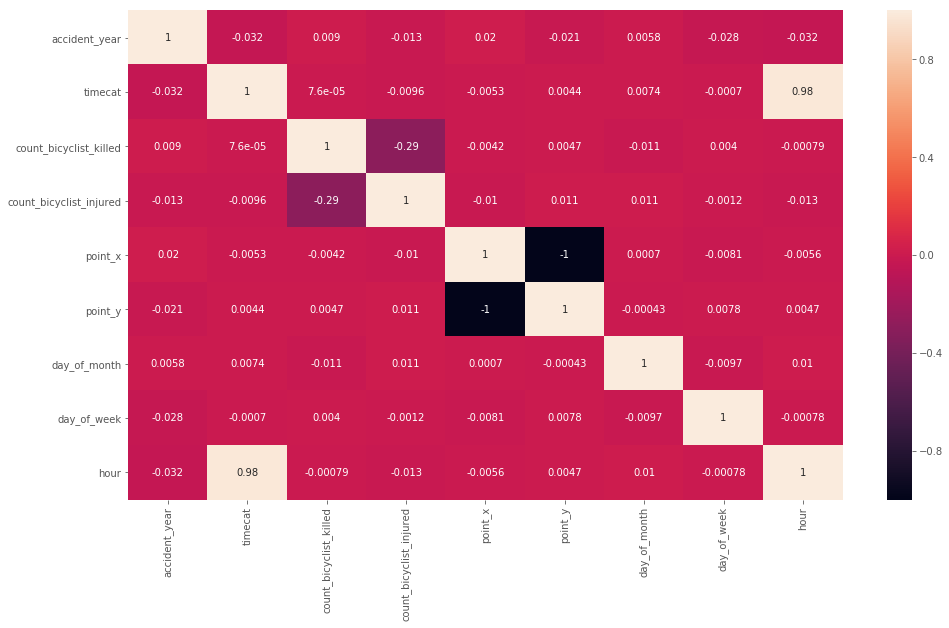

In [0]:
#show correlation between features
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)

In [0]:
df.dtypes

accident_year                       int64
collision_date                   category
timecat                             int64
collision_time                   category
primary_rd                       category
secondary_rd                     category
direction                        category
intersection                     category
hit_and_run                      category
type_of_collision                category
road_surface                     category
road_cond_1                      category
lighting                         category
bicycle_accident                 category
alcohol_involved                 category
count_bicyclist_killed              int64
count_bicyclist_injured             int64
point_x                           float64
point_y                           float64
match_addr                       category
m_primaryrd                      category
m_secondrd                       category
pcf_viol_category                category
weather_1                        c

# Exploratory Data Analysis(EDA)

In [0]:
df['day_of_month'] = df.date_time.dt.day
df['day_of_week'] = df.date_time.dt.dayofweek
df['hour'] = df.date_time.dt.hour
df.head()

,accident_year,collision_date,timecat,collision_time,primary_rd,secondary_rd,direction,intersection,hit_and_run,type_of_collision,road_surface,road_cond_1,lighting,bicycle_accident,alcohol_involved,count_bicyclist_killed,count_bicyclist_injured,point_x,point_y,match_addr,m_primaryrd,m_secondrd,pcf_viol_category,weather_1,date_time,day_of_month,day_of_week,hour
45,2017,2017-09-12,2400,21:00:00,BURBANK BL,KLUMP AV,0,Y,Not Hit and Run,Sideswipe,Dry,No Unusual Condition,C,Y,0,0,1,-118.375232,34.172203,"BURBANK BLVD & KLUMP AVE, LOS ANGELES, CA",BURBANK BLVD,KLUMP AVE,Improper Turning,Clear,2017-09-12 21:00:00,12,1,21
115,2013,2013-09-20,2400,21:30:00,DELL AVENUE,WASHINGTON BOULEVARD,0,Y,Not Hit and Run,Broadside,Dry,No Unusual Condition,C,Y,0,0,2,-118.463552,33.981106,"DELL AVE & WASHINGTON BLVD, LOS ANGELES, CA",DELL AVE,WASHINGTON BLVD,Automobile Right of Way,Clear,2013-09-20 21:30:00,20,4,21
117,2015,2015-09-09,2400,22:25:00,VARIEL AVENUE,SHERMAN WAY (1),N,N,Not Hit and Run,Broadside,Dry,No Unusual Condition,C,Y,0,0,1,-118.592855,34.201679,"VARIEL AVE & SHERMAN WAY, LOS ANGELES, CA",VARIEL AVE,SHERMAN WAY,Automobile Right of Way,Clear,2015-09-09 22:25:00,9,2,22
155,2017,2017-09-12,2400,22:00:00,MASON AV,SHERMAN WAY,N,N,Not Hit and Run,Sideswipe,Dry,No Unusual Condition,C,Y,0,0,1,-118.579761,34.201538,"MASON AVE & SHERMAN WAY, LOS ANGELES, CA",MASON AVE,SHERMAN WAY,Improper Turning,Clear,2017-09-12 22:00:00,12,1,22
172,2016,2016-09-27,2400,22:00:00,NORMANDIE AV,8TH ST,N,N,Not Hit and Run,Head On,Dry,No Unusual Condition,C,Y,0,0,1,-118.299826,34.058544,"NORMANDIE AVE & 8TH ST, LOS ANGELES, CA",NORMANDIE AVE,8TH ST,Improper Turning,Clear,2016-09-27 22:00:00,27,1,22


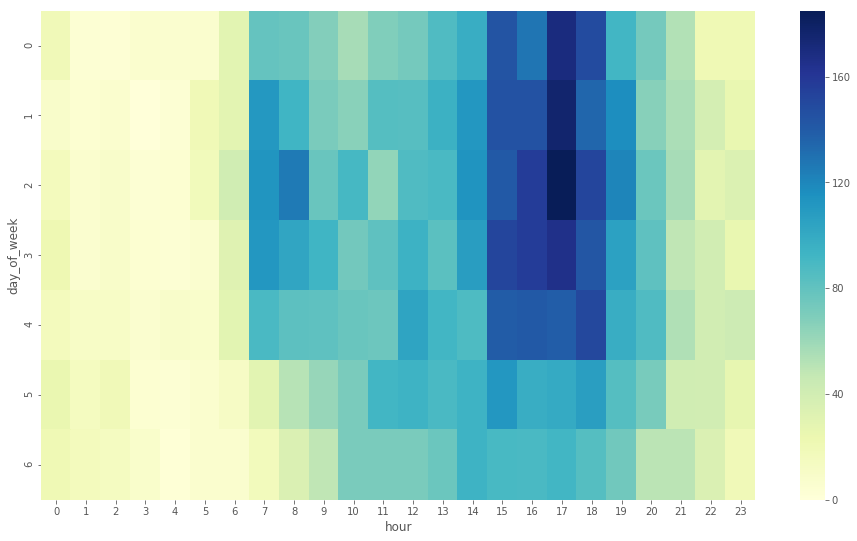

In [0]:
data = df.groupby(['day_of_week', 'hour']).count_bicyclist_injured.sum().unstack()
fig, ax = plt.subplots(figsize=(16,9))         # Sample figsize in inches
sns.heatmap(data,
            cmap="YlGnBu",
            ax=ax)

In [0]:
#The Annual Average bicycle collisions per month
print('The Annual Average bicycle collisions per month')
print(round(df.groupby('accident_year').month_.value_counts().mean()))
print()

# number of bycyclist fatalities
print("Total Bicyclist Fatalities in Los Angeles from 2013-12018: " + str(df.count_bicyclist_killed.sum()))
print()

# number of bycyclist injuries(non-fatal)
print("Total Bicyclist injuries in Los Angeles from 2013-12018: " + str(df.count_bicyclist_injured.sum()))
print()

# Bicycle collisions by year
print("Yearly Bicyclist collisions in Los Angeles from 2013-12018: ")
print(df.accident_year.value_counts().sort_index(ascending=True))
print()

# Bicycle collisions by weekday_name
print('Bicycle collisions by weekday_name')
print(df.date_time.dt.weekday_name.value_counts())
print()

# Bicycle collisions by hour
print('Bicycle collisions by hour')
print(df.date_time.dt.hour.value_counts().head())
print()

# Bicycle collisions by month
print('Bicycle collisions by month')
print(df.date_time.dt.month.value_counts().sort_index())
print()

# Most Bicycle Injuries by Year, Month
print('The month and year with the most bicycle injuries in Los Angeles 2013-2018: ')
print('May,2013 with 224 bicycle injuries')
print()
print(df.groupby(['accident_year', 'month_']).count_bicyclist_injured.sum().sort_values(ascending=False).head(1))
print()

#Day with the most bicycle collisions in Los Angeles 2013-2018
print('Days with the most bicycle collisions in Los Angeles 2013-2018')
print(df.day_of_week.value_counts())
print()

#Time when most bicycle collisions occur
print('Time when most bicycle collisions occur')
print(df.collision_time.value_counts().head())
print()

# Top 10 roads with the most bicycle collisions
print('Top 10 roads with the most bicycle collisions in Los Angeles 2013-2018')
print(df.m_primaryrd.value_counts().head(10))
print()

#Most Dangerous Intersection for bicyclists in Los Angeles 2013-2018 based on number of injuries
print('Most Dangerous Intersection for bicyclists in Los Angeles 2013-2018 based on number of injuries')
print(df[df.count_bicyclist_injured == 1].match_addr.value_counts().head())
print()

#Top 10 Most Active Intersection for Bicyclist collisions in Los Angeles 2013-2018
print('Top 10 Most Active Intersection for Bicyclist collisions')
print(df.match_addr.value_counts().head(10))
print()

#Interections vs non-intersections
print('Interections vs non-intersections')
print(df.intersection.value_counts())
print()

#Type of Bicycle Collisions
print('Type of Bicycle Collisions')
print(df.type_of_collision.value_counts())
print()

#Violation Category
print('Violation Category')
print(df.pcf_viol_category.value_counts())
print()

#Weather Conditions when bicycle collisions occured
print('Weather Conditions when bicycle collisions occured')
print(df.weather_1.value_counts())

#Road Surface when bicycle collisions occured
print('Road Surface where bicycle collisions occured')
print(df.road_surface.value_counts())
print()

#Road Conditions when bicycle collisions occured
print('Road Conditions when bicycle collisions occured')
print(df.road_cond_1.value_counts())
print()

#Hit and Run
print('Hit and Run')
print(df.hit_and_run.value_counts())
print()

The Annual Average bicycle collisions per month
179

Total Bicyclist Fatalities in Los Angeles from 2013-12018: 78

Total Bicyclist injuries in Los Angeles from 2013-12018: 10974

Yearly Bicyclist collisions in Los Angeles from 2013-12018: 
2013    2414
2014    2309
2015    2161
2016    2002
2017    1984
2018     768
Name: accident_year, dtype: int64

Bicycle collisions by weekday_name
Wednesday    1930
Thursday     1854
Tuesday      1791
Friday       1772
Monday       1635
Saturday     1440
Sunday       1216
Name: date_time, dtype: int64

Bicycle collisions by hour
17    1077
15     973
18     959
16     957
14     762
Name: date_time, dtype: int64

Bicycle collisions by month
1      900
2      987
3     1092
4     1100
5     1103
6      971
7      974
8      986
9      952
10     991
11     872
12     710
Name: date_time, dtype: int64

The month and year with the most bicycle injuries in Los Angeles 2013-2018: 
May,2013 with 224 bicycle injuries

accident_year  month_
2013           

Bicyclist injury by year


Text(0, 0.5, 'Bicyclists Injured')

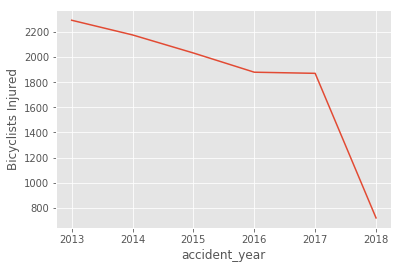

In [0]:
#bicyclist injury by year
df.groupby('accident_year').count_bicyclist_injured.sum().plot()
print('Bicyclist injury by year')
plt.ylabel('Bicyclists Injured')

Some research revealed some claims to most dangerous street in Los Angeles.
![Image of Yaktocat](https://images1.laweekly.com/imager/u/blog/6371809/los-angeles-dangerous-streets-map.png)

# Geospatial Analysis

In [46]:
m = folium.Map(location=[34.1, -118.3], 
             zoom_start=10, 
             tiles='stamenterrain', 
             min_zoom=10)

heat_df = df[['point_y', 'point_x']]
heat_data = [[row['point_y'],row['point_x']] for index, row in heat_df.iterrows()]

HeatMap(heat_data, 
        radius=5,
        max_zoom=12,
        max_val=0.7,
        ).add_to(m)


m


# Data Source

1.   Original datasource : http://geohub.lacity.org/datasets/66d96f15d4e14e039caa6134e6eab8e5_0
2.   Dataset Guide: https://peteraldhous.com/Data/ca_traffic/SWITRS_codebook.pdf


# References

- https://www.laweekly.com/news/here-are-las-most-dangerous-intersections-map-6370625
- https://www.seattle.gov/Documents/Departments/SeattleBicycleAdvisoryBoard/presentations/BPSA_Draft_Public_093016.pdf
- https://www.theurbanist.org/2017/12/28/2016-traffic-data-trends-look-bad-pedestrians-vision-zero-reach/
- https://www.outsideonline.com/2313301/would-you-ride-bike-los-angeles
- https://www.bicycling.com/culture/a23566413/los-angeles-is-the-worst-bike-city-in-america/
- https://www.nhtsa.gov/road-safety/bicycle-safety
- http://www.pedbikeinfo.org/data/factsheet_crash.cfm
- https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812507
- https://bayareabicyclelaw.com/bike-accident-statistics-reality-check-cyclists/